# 1. Set up environment

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import glob, os

import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno
import time as time
import random

from fbprophet import Prophet

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 2. Load the data
## 2.1 Nasdaq equities
Because we need to load hundreds (thousands?) of individual equity files, we'll want to (a) limit import only to essential data and date ranges, and (b) ensure that the files can be joined effectively and efficiently ...  There are a number of ways to go about doing this task, so we'll start with one that hopefully eliminates a lot of steps down the road ...

In [4]:
# start with a test import ...
test_read = pd.read_csv('../data/stocks/AA.csv')
test_read.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1962-01-02,6.532155,6.556185,6.532155,6.532155,1.536658,55900
1,1962-01-03,6.532155,6.632280,6.524145,6.632280,1.560212,74500
2,1962-01-04,6.632280,6.664320,6.632280,6.632280,1.560212,80500
3,1962-01-05,6.632280,6.656310,6.616260,6.624270,1.558326,70500
4,1962-01-08,6.608250,6.608250,6.339915,6.408000,1.507450,93800


In [5]:
# Looks good so prepare full load ...
# Make a list of all the individual file names
col_names = [f for f in glob.iglob('../data/stocks/*.csv')]
col_names[0:5]

['../data/stocks/A.csv',
 '../data/stocks/AA.csv',
 '../data/stocks/AACG.csv',
 '../data/stocks/AAL.csv',
 '../data/stocks/AAMC.csv']

In [6]:
len(col_names)

2057

In [7]:
# Clean it up ...
col_names = [c.replace('../data/stocks/', '').replace('.csv', '') for c in col_names]
col_names[0:5]

['A', 'AA', 'AACG', 'AAL', 'AAMC']

In [8]:
col_names[-1]

'FND'

Now that we have our column header list, let's import the data that goes with it ... First let's set up an empty dataframe with datetime formatted index. Since the crypto dataset only extends as far back as 2016 and eqtuities enter and leave the exchange randomly from time to time, we'll set the start of the time period to 01/01/2016. This approach will truncate some of the available data, but will help to maintain a balanced dataset and save memory/reduce processing time during prototyping.

In [10]:
start_date = '2016-01-01'
end_date = '2019-12-31'

dates = pd.date_range(start_date, end_date)

In [12]:
dates[0:3]

DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03'], dtype='datetime64[ns]', freq='D')

In [13]:
# Instantiate a new df in which to combine all the .csv files ...
df = pd.DataFrame(index=dates)

In [14]:
def name_to_path(name, base_dir='../data/stocks'):
    return os.path.join(base_dir, "{}.csv".format(str(name)))

def get_data(names, dates):
    df = pd.DataFrame(index=dates)
#     if 'AA' not in names:
#         names.insert(0, 'AA')
    
    for name in names:
        df_temp = []
        df_temp = pd.read_csv(name_to_path(name), 
                              index_col='Date', 
                              parse_dates=True, 
                              usecols=['Date', 'Adj Close'], 
                              na_values=['nan'])
        df_temp = df_temp.rename(columns = {'Adj Close': name})
        df_temp.append(df_temp)
#         return df_temp
#         break
        df = df.join(df_temp)
    return df

# Credit: an adaptation/modification of origincal logic developed by Matt Schlenker

In [15]:
stocks = get_data(col_names, dates)
stocks.tail()

,A,AA,AACG,AAL,AAMC,AAME,AAN,AAOI,AAON,AAP,...,FMN,FMNB,FMO,FMS,FMX,FMY,FN,FNB,FNCB,FND
2019-12-27,85.239998,21.58,1.40,28.335287,13.19,1.85,56.330002,11.52,49.810001,158.350006,...,13.963590,16.35,7.690406,37.430000,94.739998,13.783427,64.570000,12.450888,8.393812,50.509998
2019-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-30,84.900002,21.34,1.38,28.195801,11.20,1.92,56.869999,11.61,49.380001,159.119995,...,13.933794,16.18,7.518019,36.700001,94.559998,13.783427,64.949997,12.529941,8.125924,50.240002
2019-12-31,85.309998,21.51,1.36,28.574404,12.35,1.97,57.110001,11.88,49.410000,160.160004,...,14.003315,16.32,7.565905,36.830002,94.510002,13.832795,64.839996,12.549704,8.383890,50.810001


In [17]:
# I think we can drop empty rows of non-trading days (i.e. w/e & holidays)
stocks.dropna(how='all', inplace=True)
stocks.shape

(1006, 2057)

In [18]:
stocks.describe()

,A,AA,AACG,AAL,AAMC,AAME,AAN,AAOI,AAON,AAP,...,FMN,FMNB,FMO,FMS,FMX,FMY,FN,FNB,FNCB,FND
count,1006.000000,1006.000000,198.000000,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000,...,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000,675.000000
mean,60.239960,32.459160,1.941717,38.811607,45.133598,3.196186,41.139965,28.161258,35.547843,143.485327,...,12.748948,12.764212,8.728282,42.460049,88.639417,12.384115,41.776750,11.852828,7.065786,41.331511
std,13.033898,10.544426,0.505316,7.540920,27.884154,0.661094,13.263810,18.859562,7.645319,24.378912,...,0.651464,2.353616,1.155332,5.478158,5.975006,0.608355,9.523650,1.048559,1.364825,7.072179
min,33.516041,15.970284,0.990000,24.281271,7.990000,1.500000,20.082134,8.490000,18.895266,79.076965,...,11.431000,7.419161,4.882929,30.586760,70.744682,11.053683,21.799999,8.980393,4.385722,24.000000
25%,46.370259,22.986908,1.702500,32.474979,15.300000,2.579365,29.074752,12.370000,31.344258,130.540512,...,12.232594,12.245338,8.140127,38.725197,85.543705,11.970298,35.517499,11.070444,5.872083,36.845001
50%,64.239010,30.080000,1.860000,38.103542,43.594999,3.280149,41.238277,21.680000,34.692858,151.838356,...,12.678546,13.523224,8.909985,41.002726,89.395462,12.275249,40.480000,11.815676,7.201080,40.980000
75%,69.452875,41.967501,2.290000,44.966640,69.042501,3.697484,50.450567,40.137501,39.316917,161.147327,...,13.247403,14.353892,9.532969,47.415227,93.123821,12.655081,48.689999,12.641041,8.056609,46.895000
max,85.309998,60.230000,3.850000,56.988728,109.349998,4.787480,78.088020,99.610001,52.400280,184.367477,...,14.090483,16.370001,11.105428,55.866947,99.251297,13.931530,65.400002,14.512880,10.962568,57.500000


## 2.2 Load Crypto Currency Data
Let's load in the crypto currency data before doing any more cleaning/eda with the stock data...

In [19]:
crypto_df = pd.read_csv('../data/crypto_tradinds.csv', 
                        index_col='trade_date', 
                        parse_dates=True, 
                        usecols=['trade_date', 'price_usd', 'ticker'], 
                        na_values='nan')
crypto_df.head()

,price_usd,ticker
trade_date,,
2016-01-01,434.33,BTC
2016-01-02,433.44,BTC
2016-01-03,430.01,BTC
2016-01-04,433.09,BTC
2016-01-05,431.96,BTC


In [20]:
crypto_df.tail()

,price_usd,ticker
trade_date,,
2020-10-19,74.13000,BRAIN
2020-10-20,71.97000,BRAIN
2020-10-21,76.64000,BRAIN
2020-10-22,80.90000,BRAIN
2020-10-19,0.15004,DAOFI


In [21]:
# Obviously the format is different here ...

In [23]:
crypto_df['ticker'].value_counts()

BIT      3011
SCC      2813
GCC      2809
BITS     2528
PUT      2517
         ... 
SSL         4
YFED        4
ESAX        1
$WBNB       1
DAOFI       1
Name: ticker, Length: 3764, dtype: int64

In [24]:
# Data appears to be quite choppy ...  Hmmm...

In [25]:
# Maybe let's reformat first so it's more like the stocks structure ...
crypto_df['ticker'].unique()

array(['BTC', 'ETH', 'XRP', ..., 'DOKI', 'BRAIN', 'DAOFI'], dtype=object)

In [45]:
# We'll want to deconstruct the current formatting of the crypto_df
# Frame out the destination structure ...
new_cols = crypto_df['ticker'].unique()

# note that we could simply reuse the "Dates" list for the index, 
# but we may want different ranges ... 

start_date_c = '2016-01-01'
end_date_c = '2019-12-31'

new_ind = pd.date_range(start_date_c, end_date_c)

new_df = pd.DataFrame(data=None, 
                      index=new_ind)

new_df.head()

""
2016-01-01
2016-01-02
2016-01-03
2016-01-04
2016-01-05


In [46]:
# add in the col structure ...
new_df = pd.DataFrame(index=dates, 
                      columns=new_cols)
new_df.head() # check it

,BTC,ETH,XRP,MKR,LTC,USDT,BCH,XLM,EOS,BNB,...,MTLX,INDEX,WOA,HAUT,THRM,YFED,NMT,DOKI,BRAIN,DAOFI
2016-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
# Now the tricky part of filling in the new frame correctly ...
for i,r in crypto_df.iterrows():
    new_df.at[i,r['ticker']] = r['price_usd']

In [48]:
new_df.head()

,BTC,ETH,XRP,MKR,LTC,USDT,BCH,XLM,EOS,BNB,...,MTLX,INDEX,WOA,HAUT,THRM,YFED,NMT,DOKI,BRAIN,DAOFI
2016-01-01,434.33,0.948024,0.005955,NaN,3.51,1,NaN,0.001748,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-02,433.44,0.937124,0.006065,NaN,3.5,1,NaN,0.001741,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-03,430.01,0.971905,0.006017,NaN,3.48,1,NaN,0.001744,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-04,433.09,0.95448,0.005958,NaN,3.5,1,NaN,0.001748,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-05,431.96,0.950176,0.006044,NaN,3.47,1,NaN,0.001721,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
new_df.describe()

,BTC,ETH,XRP,MKR,LTC,USDT,BCH,XLM,EOS,BNB,...,MTLX,INDEX,WOA,HAUT,THRM,YFED,NMT,DOKI,BRAIN,DAOFI
count,1735.00,1735.0,1734.00,1066.00,1735.00,1739.0,1167.00,1735.000000,1189.00,1163.00,...,4.000000,4.00,4.0,4.00,4.0,4.00,4.00000,4.00,4.0,1.00000
unique,1729.00,1638.0,1692.00,1054.00,1337.00,417.0,1159.00,1643.000000,635.00,921.00,...,4.000000,4.00,4.0,4.00,4.0,4.00,4.00000,4.00,4.0,1.00000
top,6741.75,11.0,1.14,504.46,3.84,1.0,230.11,0.001888,2.62,9.52,...,0.944449,3.05,483.6,2.44,15.2,3.57,0.04163,112.34,80.9,0.15004
freq,2.00,4.0,5.00,2.00,17.00,943.0,2.00,4.000000,12.00,4.00,...,1.000000,1.00,1.0,1.00,1.0,1.00,1.00000,1.00,1.0,1.00000


In [50]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1755 entries, 2016-01-01 to 2020-07-17
Columns: 3765 entries, BTC to DAOFI
dtypes: object(3765)
memory usage: 50.5+ MB


In [51]:
new_df.dtypes

BTC      object
ETH      object
XRP      object
MKR      object
LTC      object
          ...  
YFED     object
NMT      object
DOKI     object
BRAIN    object
DAOFI    object
Length: 3765, dtype: object

In [52]:
new_df = new_df.astype('float')

In [53]:
new_df.describe()

,BTC,ETH,XRP,MKR,LTC,USDT,BCH,XLM,EOS,BNB,...,MTLX,INDEX,WOA,HAUT,THRM,YFED,NMT,DOKI,BRAIN,DAOFI
count,1735.000000,1735.000000,1734.000000,1066.000000,1735.000000,1739.000000,1167.000000,1735.000000,1189.000000,1163.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,1.00000
mean,5582.779925,229.328333,0.284632,590.628002,56.069568,1.000740,539.092716,0.096947,4.692335,14.536080,...,0.935448,4.400000,421.680000,2.415000,15.977500,3.762500,0.039061,332.630000,75.910000,0.15004
std,4021.409107,228.928871,0.334293,224.607035,54.807405,0.009914,521.461373,0.119650,3.351145,8.400249,...,0.047284,2.015755,44.011519,0.120139,2.049429,0.189978,0.001975,276.895657,3.835144,NaN
min,364.330000,0.937124,0.005112,22.650000,3.000000,0.913595,77.370000,0.001444,0.493225,0.099867,...,0.886861,3.050000,387.130000,2.290000,14.400000,3.570000,0.037032,74.230000,71.970000,0.15004
25%,1117.080000,20.100000,0.008651,455.897500,4.730000,0.999997,233.215000,0.002647,2.590000,9.390000,...,0.906852,3.402500,392.057500,2.342500,15.000000,3.645000,0.037867,102.812500,73.590000,0.15004
50%,6218.300000,185.440000,0.241628,546.190000,47.220000,1.000000,325.610000,0.062793,3.590000,14.260000,...,0.928982,3.575000,407.995000,2.400000,15.260000,3.735000,0.038791,337.925000,75.385000,0.15004
75%,8805.330000,300.650000,0.332120,668.812500,71.060000,1.000000,616.775000,0.118521,5.820000,19.425000,...,0.957578,4.572500,437.617500,2.472500,16.237500,3.852500,0.039985,567.742500,77.705000,0.15004
max,19497.400000,1396.420000,3.380000,1690.190000,358.340000,1.080000,3923.070000,0.896227,21.540000,38.820000,...,0.996967,7.400000,483.600000,2.570000,18.990000,4.010000,0.041630,580.440000,80.900000,0.15004


# 3. EDA & Visual Inspection
Now that the dataframes seem to be correctly formatted, let's look at the missing values in more detail to figure out what to do about it (i.e. drop rows/cols for rapid prototyping or maybe interolate & fill ... not sure yet ...

In [61]:
print(f'NA counts in Cryptos Data: \n{new_df.isna().sum()}\n') 
print(f'NA Counts in Stocks Data: \n{stocks.isna().sum()}')

NA counts in Cryptos Data: 
BTC        20
ETH        20
XRP        21
MKR       689
LTC        20
         ... 
YFED     1751
NMT      1751
DOKI     1751
BRAIN    1751
DAOFI    1754
Length: 3765, dtype: int64

NA Counts in Stocks Data: 
A         0
AA        0
AACG    808
AAL       0
AAMC      0
       ... 
FMY       0
FN        0
FNB       0
FNCB      0
FND     331
Length: 2057, dtype: int64


Perhaps unsurprisingly, Crypto currencies are relatively new, there seem to be a lot more, and very material holes in that data set, compared to the Nasdaq stocks ...

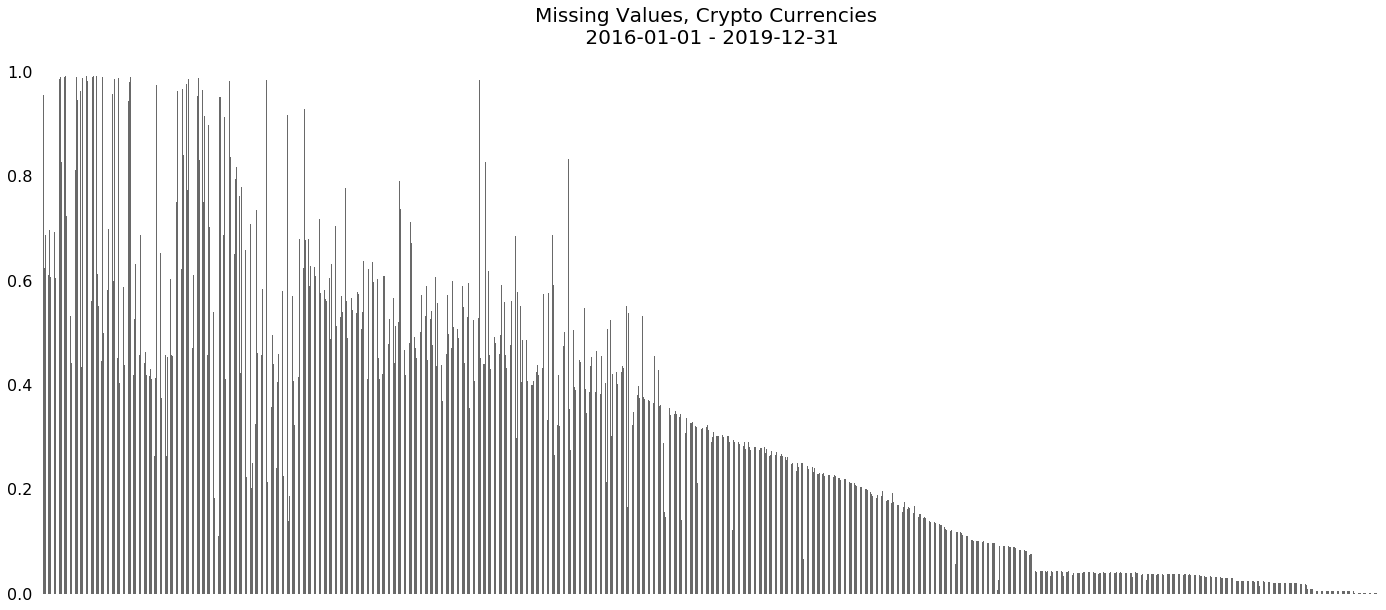

In [62]:
# Need a higher level picture ...
msno.bar(new_df)
plt.title('Missing Values, Crypto Currencies \n 2016-01-01 - 2019-12-31', fontsize=20);

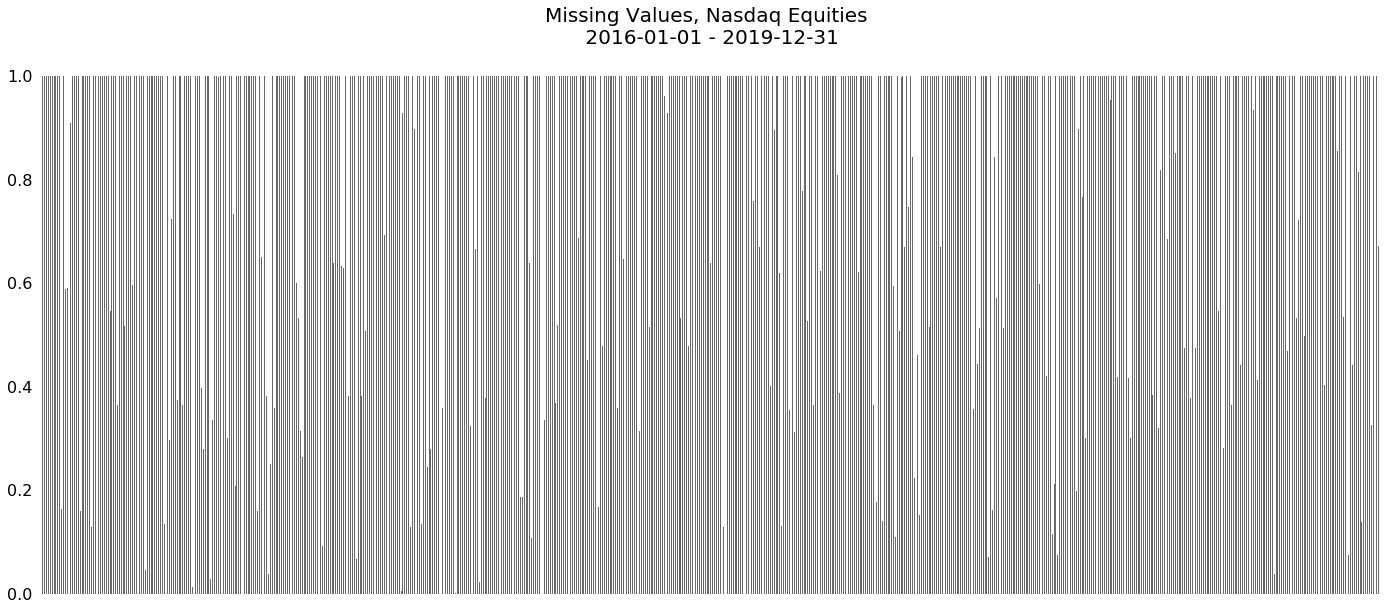

In [63]:
msno.bar(stocks)
plt.title('Missing Values, Nasdaq Equities \n 2016-01-01 - 2019-12-31', fontsize=20);

In [64]:
# That's a big difference ...
# Dropping serie with too many missing values ...
# Setting threshold to cols with more than 80% missing vals

drop_threshold = len(stocks) * .80
sts = stocks.dropna(thresh=drop_threshold, axis=1)
sts.shape

(1006, 1676)

In [65]:
stocks.shape, sts.shape

((1006, 2057), (1006, 1676))

In [66]:
# And now for Cryptos ...

cryps = new_df.dropna(thresh=drop_threshold, axis=1)
new_df.shape, cryps.shape

((1755, 3765), (1755, 1099))

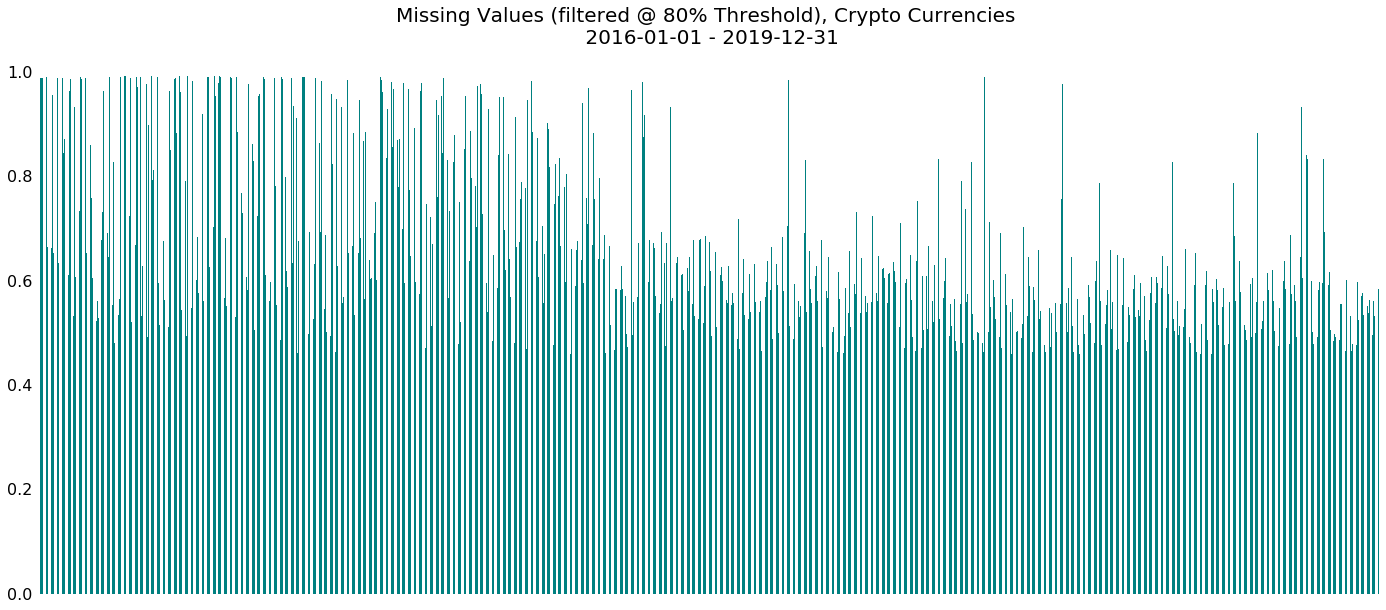

In [67]:
# Let's regraph as well ...
msno.bar(cryps, color='teal')
plt.title('Missing Values (filtered @ 80% Threshold), Crypto Currencies \n 2016-01-01 - 2019-12-31', 
          fontsize=20);

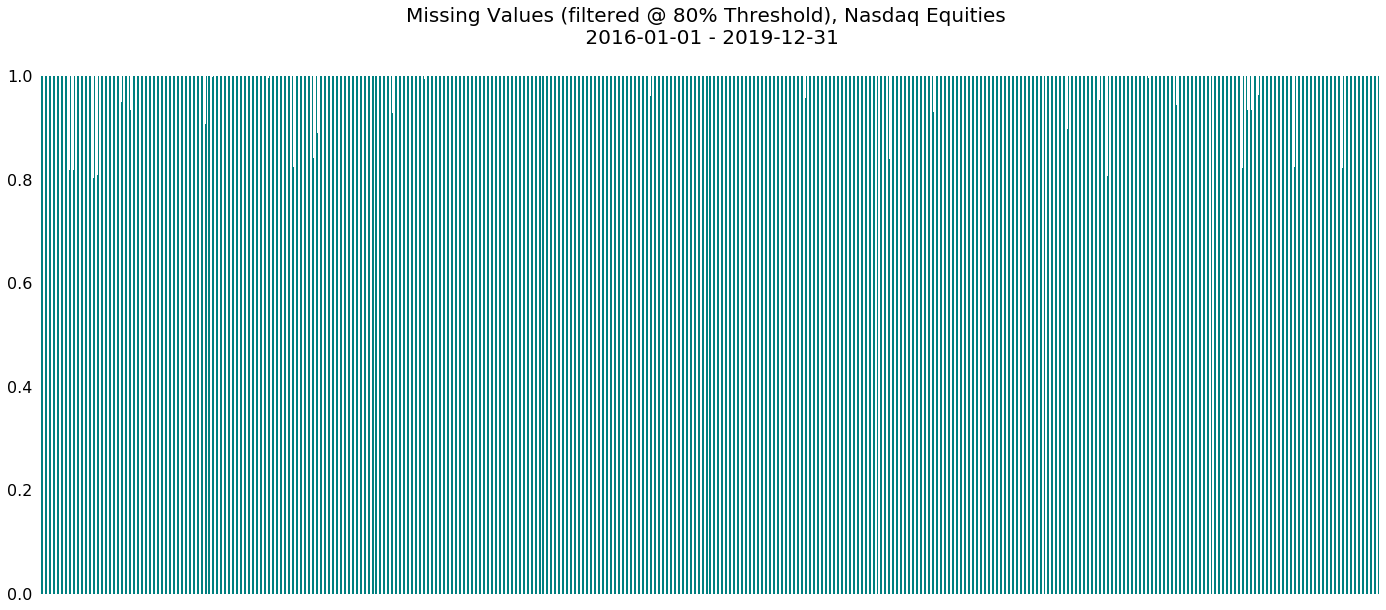

In [68]:
msno.bar(sts, color='teal')
plt.title('Missing Values (filtered @ 80% Threshold), Nasdaq Equities \n 2016-01-01 - 2019-12-31', 
          fontsize=20);

An improvement but still not great.  FBProphet can handle some degree of missing values, one of the reasons to try it as a first option for modeling, given the constraints, but remains to be seen if more culling will be necessary.

Being time series data, I'd normally want to look at stationarity (unit roots), seasonality, cyclicality, etc. in the data, but with so many serie, it's not so practical, especially given the clock ...  But maybe try to have a look ...

In [69]:
# Let's bring in some additional packages - let's look at stationarity ...
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split

In [70]:
# This code came out of my GA Data Science Immersive program, 
# though I forget the exact lecture/author 
# the raw output from the ADF test is a bit unwieldy and this helps to make it readable

def interpret_df_test(dftest):
#     for col in data: # add iteration to examine entire df
    dfout = pd.DataFrame(dftest[0:2], index=['Test Statistic', 'p-value'])
    return dfout

In [72]:
adftest = pd.DataFrame(interpret_df_test(adfuller(sts['AA'])).T)
adftest

,Test Statistic,p-value
0,-1.295687,0.631143


In [73]:
# I think this could be an interesting path to explore, but I'll revisit if time.
# Prophet can handle stationarity, etc., so perhaps not immediately worth the time expense ...

# 3. Model

Given time constraints, the volume of individual series to be forecast, and uncertainties around the characteristics of each series (i.e. stationarity, seasonaility, etc.), I think it makes sense to build an initial forecast with the FBProphet algorithm, rather than more traditional TSA approach.  The Prophet algorithm is known to be very flexible in handling TS data with characteristics that would require direct intervention with more econometric-based approaches (i.e. parametric-based, and relying on certain statistical conditions to be maintained), and it allows for the forcasting of multiple series in one model, which is advantageous here.  Another approach that I considered for this scenario was a random forest approach, but I'm curious to see (a) if I can get prophet to work with so many serie and (b) if it lives up to its handling abilities ...

**Note**
If you have not run FBProphet before, you likely will need to ```pip install pystan```, followed by ```pip install fbprophet``` in the terminal or directly in jupyter notebook.  Since I've already imported the necessary libraries, I'll dive right in ...

In [74]:
# Setting a random seed for reproducibility
random.seed(47)

In [83]:
# Before we can do anything, Prophet is very particular about data formatting
# Need a two-col df, with datetime col (not the index!!) labeled "ds", and "y"
# column (which we'll populate with our price observations).  We'll have to do
# this for each serie, but let's start with a test ...

test_AA = pd.DataFrame(index=sts.index)
test_AA['ds'] = sts.index
test_AA['y'] = sts[['AA']]
test_AA.head()

,ds,y
2016-01-04,2016-01-04,23.007635
2016-01-05,2016-01-05,21.965065
2016-01-06,2016-01-06,20.401209
2016-01-07,2016-01-07,19.595585
2016-01-08,2016-01-08,19.121691


In [85]:
# Fit a test model - quick & dirty
test_model = Prophet(yearly_seasonality=True, 
                     daily_seasonality=True)
test_model.fit(test_AA)

In [86]:
# Create the forecast space ...
day_range = 365
test_fc = test_model.make_future_dataframe(periods=day_range, 
                                           freq='D')
test_fc.tail()

,ds
1366,2020-12-26
1367,2020-12-27
1368,2020-12-28
1369,2020-12-29
1370,2020-12-30


In [87]:
# Populate the forecast with preds ...
test_fc = test_model.predict(test_fc)
test_fc[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail() # just the most important output

,ds,yhat,yhat_lower,yhat_upper
1366,2020-12-26,14.720907,1.627480,27.208055
1367,2020-12-27,14.889585,1.812224,27.983348
1368,2020-12-28,14.046079,0.771214,26.895151
1369,2020-12-29,14.310831,1.013699,27.897723
1370,2020-12-30,14.511550,0.664926,27.680685


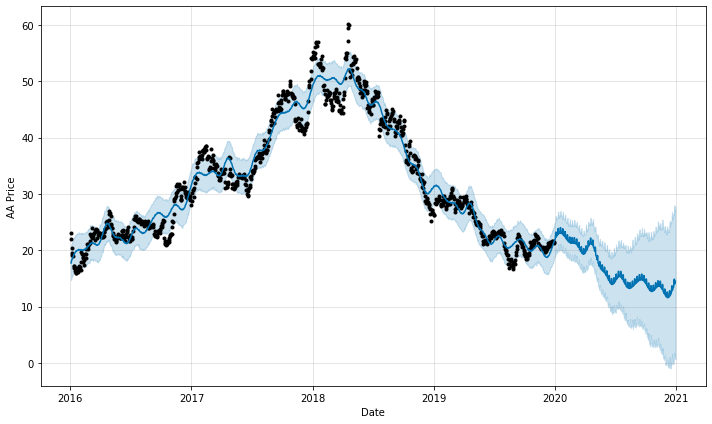

In [88]:
# Let's have a look
test_model.plot(test_fc, 
                xlabel='Date', 
                ylabel='AA Price');
# Note the uncertainty spread the further out you go ...

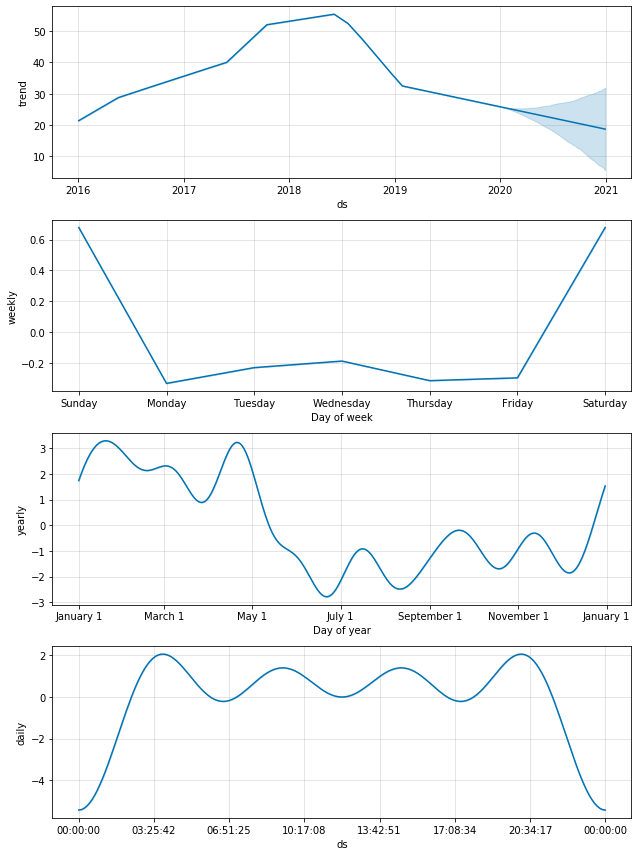

In [90]:
# breaking it down a bit more ...
test_AA_figs = test_model.plot_components(test_fc)
plt.show()

# 3.1 Build a Prophet Engine ...

In [ ]:
# We need to format each asset series to pass throught prophet algorythm
# def data_prep(col):
#     for c in data:
#         temp_serie['y'] = data[col]
#         temp_serie['ds'] = data.index

# def run_prophet_engine(data, column_names):
#     fc_table = pd.DataFrame(index=data.index)
#     for column in column_names:
#         # structure the incoming data for prophet compatibility
#         temp_df = []
#         temp_df['ds'] = data.index
#         temp_df['y'] = data[column]
#         return temp_df.head()
#         break
        
#         # instantiate model ...
#         temp_model = Prophet(yearly_seasonality=True,
#                            daily_seasonality=True)
#         temp_model.fit(temp_serie)
#         temp_forecast = temp_model.make_future_dataframe(periods=365,
#                                                          include_history=False)
#         temp_forecast = temp_model.predict(forecast)
#         return temp_forecast
#         break

In [91]:
# Let's try a test on one series first ...
def run_prophet(series):
    mod = Prophet(yearly_seasonality=False,
                  daily_seasonality=False)
    mod.fit(series)
    forecast = mod.make_future_dataframe(periods=365, 
                                           include_history=False)
    forecast = mod.predict(forecast)
    return forecast

In [92]:
run_prophet(test_AA)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-01,18.625566,14.548767,21.745273,18.625566,18.625566,-0.561884,-0.561884,-0.561884,-0.561884,-0.561884,-0.561884,0.0,0.0,0.0,18.063682
1,2020-01-02,18.594764,14.033126,21.648342,18.594764,18.594764,-0.668022,-0.668022,-0.668022,-0.668022,-0.668022,-0.668022,0.0,0.0,0.0,17.926742
2,2020-01-03,18.563963,14.185121,21.391709,18.563963,18.563963,-0.680021,-0.680021,-0.680021,-0.680021,-0.680021,-0.680021,0.0,0.0,0.0,17.883942
3,2020-01-04,18.533161,16.729384,23.469928,18.533161,18.533161,1.607138,1.607138,1.607138,1.607138,1.607138,1.607138,0.0,0.0,0.0,20.140300
4,2020-01-05,18.502359,16.682183,23.766859,18.502359,18.502359,1.607138,1.607138,1.607138,1.607138,1.607138,1.607138,0.0,0.0,0.0,20.109498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2020-12-26,7.536970,-1.665325,19.875533,-2.245076,17.215818,1.607138,1.607138,1.607138,1.607138,1.607138,1.607138,0.0,0.0,0.0,9.144109
361,2020-12-27,7.506169,-0.972110,19.383048,-2.314048,17.266459,1.607138,1.607138,1.607138,1.607138,1.607138,1.607138,0.0,0.0,0.0,9.113307
362,2020-12-28,7.475367,-3.923011,16.611462,-2.383021,17.283861,-0.722574,-0.722574,-0.722574,-0.722574,-0.722574,-0.722574,0.0,0.0,0.0,6.752793
363,2020-12-29,7.444565,-3.780097,17.837390,-2.451994,17.298643,-0.581776,-0.581776,-0.581776,-0.581776,-0.581776,-0.581776,0.0,0.0,0.0,6.862789


In [94]:
# Putting the pieces together to make the engine ...
# def data_prep(data):
#     for column in data:
#         temp_serie = pd.DataFrame()
#         temp_serie['y'] = data[column]
#         temp_serie['ds'] = data.index
#         return temp_serie
#         break

def prophet_engine(data):
    forecasts = []
    for column in data:
        temp_serie = pd.DataFrame()
        temp_serie['y'] = data[column]
        temp_serie['ds'] = data.index
#         return temp_serie
#         break        
        mod = Prophet(yearly_seasonality=True,
                      daily_seasonality=True)
        mod.fit(temp_serie)
        forecast = mod.make_future_dataframe(periods=365, 
                                           include_history=False)
        forecast = mod.predict(forecast)
        forecast = forecast[['ds', 'yhat_lower', 'yhat_upper', 'yhat']].rename(columns={'yhat': f'yhat_{column}'})
        forecasts.append(forecast)
    return forecasts
#         break

In [95]:
# Test with just a few serie ...
prophet_engine(sts.iloc[:, 0:5])

[            ds  yhat_lower  yhat_upper     yhat_A
 0   2020-01-01   77.818018   83.840052  80.710743
 1   2020-01-02   78.182860   83.751062  80.958955
 2   2020-01-03   78.339278   84.105690  81.279586
 3   2020-01-04   79.811029   85.632898  82.582818
 4   2020-01-05   80.064892   85.806054  82.800946
 ..         ...         ...         ...        ...
 360 2020-12-26   73.861394  108.471699  91.149132
 361 2020-12-27   73.992719  108.223457  91.243552
 362 2020-12-28   73.098835  107.411354  90.132691
 363 2020-12-29   72.387472  107.894798  90.294055
 364 2020-12-30   73.376287  108.112182  90.364470
 
 [365 rows x 4 columns],             ds  yhat_lower  yhat_upper    yhat_AA
 0   2020-01-01   18.927942   24.925293  21.855233
 1   2020-01-02   18.843860   24.925224  21.873571
 2   2020-01-03   19.037496   25.305167  22.030014
 3   2020-01-04   19.981685   26.196478  23.134612
 4   2020-01-05   20.206014   26.288468  23.257594
 ..         ...         ...         ...        ...
 360 

The function works but takes WAAAY too long to fun on my relatively weak laptop - found a suggested solution to leverage multiprocessing with prophet ...

In [96]:
import multiprocessing
from multiprocessing import Pool, cpu_count

In [97]:
p = Pool(cpu_count())
s_preds = prophet_engine(sts.iloc[:, 0:5])
p.close()
p.join()

# Credit to Matias Aravena Gamboa for demonstrating multiprocessing with FB Prophet

In [98]:
s_preds

[            ds  yhat_lower  yhat_upper     yhat_A
 0   2020-01-01   77.927113   83.681565  80.710743
 1   2020-01-02   78.043534   83.884646  80.958955
 2   2020-01-03   78.493266   84.303331  81.279586
 3   2020-01-04   79.496376   85.396588  82.582818
 4   2020-01-05   79.693272   85.897433  82.800946
 ..         ...         ...         ...        ...
 360 2020-12-26   75.771504  105.863133  91.149132
 361 2020-12-27   76.101601  106.164099  91.243552
 362 2020-12-28   74.351298  105.251586  90.132691
 363 2020-12-29   74.714938  105.735240  90.294055
 364 2020-12-30   75.115574  105.652785  90.364470
 
 [365 rows x 4 columns],             ds  yhat_lower  yhat_upper    yhat_AA
 0   2020-01-01   18.669267   24.712456  21.855233
 1   2020-01-02   18.635999   24.743399  21.873571
 2   2020-01-03   19.053157   25.042079  22.030014
 3   2020-01-04   20.161139   26.206039  23.134612
 4   2020-01-05   20.299143   26.236221  23.257594
 ..         ...         ...         ...        ...
 360 

**Note** I found no discernible improvement, given I'm running a two-core machine with low clock speads, but I think this apprach could yield dividends if pursued on platform with more available cores.

Given the time limit - I'm effectively out of time - I will have to stop here.

In any case, immediate next steps would be as follows:
1. Process full datasets via the ```prophet_engine``` function, equities and currencies, transform output if necessary in order to extract 12/31/20 predicted values and difference against respective 12/31/19 values.
- Note that it's possible to output the original values in the prophet output tables for more immediate comparisons, but I refrained to reduce computational and memory load to facilitate prototyping.
2. Evaluate errors (via test metrics, e.g. RMSE, or similar) - this is a very important step!!
3. Prpcess that data to reveal ```.max()``` value, along with probability range(s) (i.e. the confidence intervals.  Note that the CI can be tuned in Prophet ...
4. At that point, I would want to go back to the data to dig into it a bit more, especially the question of which serie to keep and which to drop because of the missing values.
5. After revisitng the data, I would like to split the data (assuming enough exists to do so) such that we have three years for training set and one year (2019) for testing.  Then I would further validate against fully unseen 2020 data at the very end, after model tuning.
6. Model tuning, gridsearch/pipeline parameters that can be adjusted to refine model performance and test against evaluation metrics (e.g. RMSE, or similar).
7. Depending on outcome(s), experiment with other models, e.g. random forests/gradient boosted random forests, as a start.

Finally, I would write the funciton that would allow a user to manually input a date (e.g. ```DateTime(input())``` ...) and then return the YTD asset appreciation.